# FRAUDULENT TRANSACTION CLASSIFICATION

by Diego Unzueta, https://diegounzuetaruedas.medium.com/

## Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Dataset

The dataset can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Kaggle dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
try:
    import opendatasets as od
except:
    print("Installing opendatasets")
    !pip install opendatasets
    import opendatasets as od

Installing opendatasets


In [3]:
try:
    df = pd.read_csv("./creditcardfraud/creditcard.csv")

except Exception as e:
    print("Downloading dataset")
    od.download("https://www.kaggle.com/mlg-ulb/creditcardfraud")
    try:
        df = pd.read_csv("./creditcardfraud/creditcard.csv")
    except:
        raise

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  diegounzu


Your Kaggle Key:

  ································


100%|█████████████████████████████████████████████████████████████████████████████| 66.0M/66.0M [00:24<00:00, 2.81MB/s]


In [10]:
df["Class"].values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Text(0, 0.5, 'Transactions')

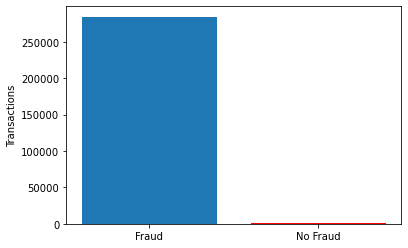

In [14]:
plt.bar(["Fraud", "No Fraud"], np.bincount(df["Class"].values), color = ["C0", "r"])
plt.ylabel("Transactions")

# EDA

Before starting any project I like doing a good exploratory data analysis. Making sure you properly understand the data may save you a lot of time when coding later on.

$\textbf{Some key things I always explore:}$
- Properties: size, types (inconsistencies?), distribution parameters like means, standard deviations, min, max
- Duplicates: Are there any duplicate rows, should I remove them?
- Uniques (for categorical values)
- Missing Values (can do heatmaps or bar charts if you are writing a report)

$\textbf{Depending on the dataset you might want to:}$
- check for outliers (IQR box plots)

$\textbf{Further analysis might include:}$
- Pairwise Scatters
- Distributions
    - For continuous variables plot histograms
    - For categorical plot bar charts 
- Correlation analysis (at least pearson's linear correlation)

$\textbf{For Sparse Datasets:}$
- Feature selection
    - Linear Regression (P values, Lasso L1)
    - Decision trees
    - Correlations and analysis

## Looking at generic data properties

$\textbf{Size:}$

In [4]:
print("Dataset size:", df.shape)

Dataset size: (284807, 31)


In [5]:
print("out of which", len(df.loc[df["Class"] == 1]), "are fraudulent, or ",round(len(df.loc[df["Class"] == 1])/len(df), 3)*100, "%"  )

out of which 492 are fraudulent, or  0.2 %


$\textbf{Duplicates:}$

In [6]:
print("There are ", df.duplicated().sum(), "duplicate transactions out of which ", df.loc[df.duplicated()]["Class"].sum(), "are fraudulent")

There are  1081 duplicate transactions out of which  19 are fraudulent


19/1081 might not seem like a lot but that is considerably higher than the ratio of fraudulent transactions (around 1.76% of duplicate transactions are fraudulent, and around 3.9% of fraudulent transactions are duplicates).

I probably wont use this but it is still an interesting observation and could be used to improve the model further

$\textbf{The Data:}$

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset contains 28 unknown PCA variables about each transaction, the time of transacton, the amount transfered and finally the "class" binary variable to encode fraudulence

$\textbf{Amount and class distributions:}$

In [8]:
df[["Amount", "Class"]].describe().round(3)

,Amount,Class
count,284807.000,284807.000
mean,88.350,0.002
std,250.120,0.042
min,0.000,0.000
25%,5.600,0.000
50%,22.000,0.000
75%,77.165,0.000
max,25691.160,1.000


Most of the data is non fraudulent, average transaction is $88

$\textbf{Missing values or inconsistent types:}$

In [9]:
a = pd.DataFrame([df.isna().sum(), df.dtypes]).T
a.columns = ["Missing Values", "Type"]
a

,Missing Values,Type
Time,0,float64
V1,0,float64
V2,0,float64
V3,0,float64
V4,0,float64
V5,0,float64
V6,0,float64
V7,0,float64
V8,0,float64
V9,0,float64


There are no missing values or inconsistent data types

## Visualisations

Here I focus on visualisations to do with fraudulent transactions because it is what we are interested in. It is difficult sometimes to do with a dataset this unbalanced

### FRAUD

In [10]:
fraud = df.loc[df["Class"] == 1]
nofraud = df.loc[df["Class"] == 0]

In [151]:
def plot_data(fraud, nofraud = None, labels = None, features=None, box = True):
    """
    Input: 2 dataframes, fraudulent transactions and non fraudulent
           list of features to visualise 
    
    Output:
    normalised histograms of the selected features
    """
    
    if features == None:
        features = df.columns
    
    try:
        fraud = fraud[features]
        nofraud = nofraud[features]

    except:
        
        raise
        return()
    
    n_rows = len(features)//2 +1

    _, ax = plt.subplots(n_rows, 2, figsize = (5*2, 5*n_rows))
    
    if labels == None:
        labels = ["Not Fraudulent","Fraudulent"]
    
    nofraud["data"] = labels[0]  
    fraud["data"] = labels[1]

    if box == True:
        joint = pd.concat([fraud, nofraud], axis = 0)

    for index, i in enumerate(features):
        axis = ax[index//2][index%2]
        
        if box == True:
            sns.boxplot(data = joint, x = "data", y = i, ax = axis)
        else:
            axis.hist(nofraud[i], density = True, bins = 50, stacked = True, label = labels[0])
            axis.hist(fraud[i], bins = 50, density = True, stacked = True, label = labels[1])
            axis.legend()
            
        axis.set_title(i)
        axis.set_ylabel("Transactions")
        axis.set_xlabel("Value of {}".format(i))
        
    plt.tight_layout()

<ipython-input-151-0bcc0477b8b6>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nofraud["data"] = labels[0]
<ipython-input-151-0bcc0477b8b6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud["data"] = labels[1]


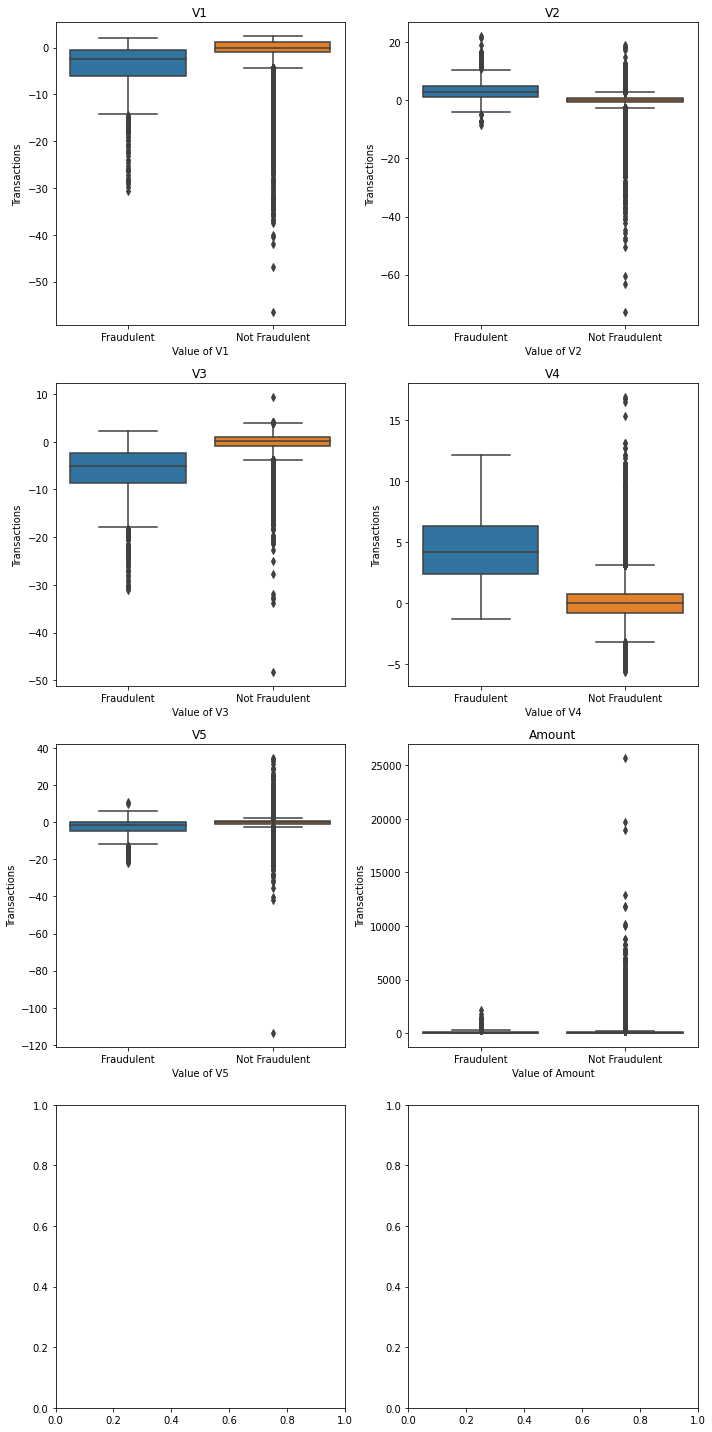

In [152]:
plot_data(fraud, nofraud = nofraud, features = ["V1", "V2", "V3", "V4", "V5", "Amount"])

### AMOUNT AND FRAUD

I'm curious about the amount transfered and the fraud. Amount is the only variable we know other than time and fraud

<ipython-input-13-4116f14ad675>:2: RuntimeWarning: divide by zero encountered in log
  ax[1].plot(np.log(sorted(df["Amount"])))


Text(0, 0.5, 'Amount')

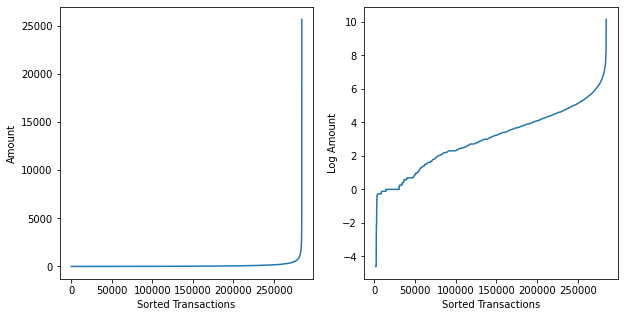

In [13]:
_, ax = plt.subplots(1,2, figsize= (10, 5))
ax[1].plot(np.log(sorted(df["Amount"])))
ax[1].set_xlabel("Sorted Transactions")
ax[1].set_ylabel("Log Amount")

ax[0].plot(sorted(df["Amount"]))
ax[0].set_xlabel("Sorted Transactions")
ax[0].set_ylabel("Amount")

<ipython-input-14-3a7ef4c47dca>:2: RuntimeWarning: divide by zero encountered in log
  ax[1].scatter(np.linspace(0, 1, len(fraud)), np.log(sorted(fraud["Amount"])), s = 1, label = "Fraud")
<ipython-input-14-3a7ef4c47dca>:3: RuntimeWarning: divide by zero encountered in log
  ax[1].scatter(np.linspace(0, 1, len(nofraud)), np.log(sorted(nofraud["Amount"])), s =1, label = "No Fraud")


Text(0, 0.5, 'Amount')

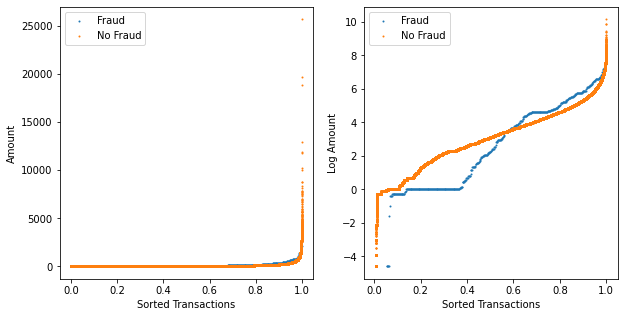

In [14]:
_, ax = plt.subplots(1,2, figsize= (10, 5))
ax[1].scatter(np.linspace(0, 1, len(fraud)), np.log(sorted(fraud["Amount"])), s = 1, label = "Fraud")
ax[1].scatter(np.linspace(0, 1, len(nofraud)), np.log(sorted(nofraud["Amount"])), s =1, label = "No Fraud")
ax[1].legend()
ax[1].set_xlabel("Sorted Transactions")
ax[1].set_ylabel("Log Amount")

ax[0].scatter(np.linspace(0, 1, len(fraud)), sorted(fraud["Amount"]), s = 1, label = "Fraud")
ax[0].scatter(np.linspace(0, 1, len(nofraud)), sorted(nofraud["Amount"]), s =1, label = "No Fraud")
ax[0].legend()
ax[0].set_xlabel("Sorted Transactions")
ax[0].set_ylabel("Amount")

In [15]:

def plot_box(frame):
    
    _, ax = plt.subplots(1,2, figsize= (10, 5))
    sns.boxplot(data = frame,  x = "Class", y = "Amount",ax = ax[0])
    
    frame["Amount_log"] = np.log(df["Amount"])
    sns.boxplot(data = frame,  x = "Class", y = "Amount_log",ax = ax[1])

C:\Users\UnzuetaRuedasD\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


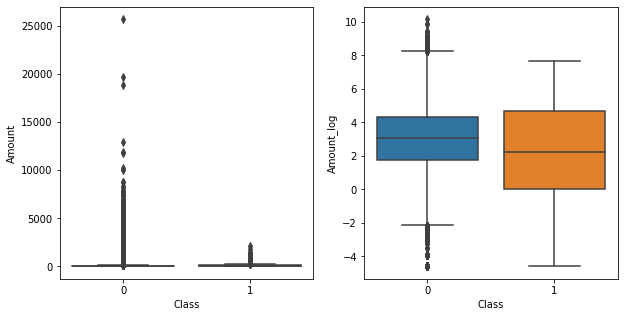

In [16]:
plot_box(df)

Fraudulent transactions seem to have a larger spread than non fraudulent transactions and a lower mean

In [17]:
df = df.drop("Amount_log", axis =1)

## Belford's law

Fraudulent transactions don't follow belford's law as well as non-fraudulent transactions

Belford's law appears many places in mathematics like the Fibonacci sequence and the Collatz conjecture. It is a law that dictates the distribution of the first digit of these numbers. As you can see, the fradulent data follows Belford's law much better than the fraudulent transactions 

In [18]:
#these are the Benford Law weights)
weights = np.asarray([0.301, 0.176, 0.124, 0.096, 0.079, 0.066, 0.057, 0.054, 0.047])

In [19]:
def get_belford_list(df):
    l = []
    for i in df["Amount"]:
        l.append(int(str(i)[0]))
    l = sorted([i for i in l if i != 0])
    return(l)

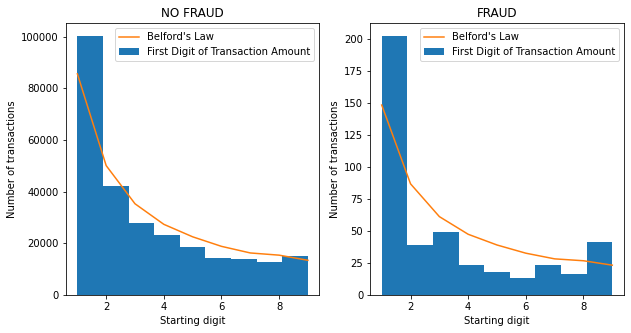

In [20]:
_, ax = plt.subplots(1, 2, figsize=  (10, 5))
ax[0].hist(get_belford_list(nofraud), bins = 9, label = "First Digit of Transaction Amount")
ax[0].plot(range(1, 10), weights*len(nofraud), label = "Belford's Law")
ax[0].set_xlabel("Starting digit")
ax[0].set_ylabel("Number of transactions")
ax[0].set_title("NO FRAUD")
ax[0].legend()

ax[1].hist(get_belford_list(fraud), bins = 9, label = "First Digit of Transaction Amount")
ax[1].plot(range(1, 10), weights*len(fraud), label = "Belford's Law")
ax[1].set_xlabel("Starting digit")
ax[1].set_ylabel("Number of transactions")
ax[1].set_title("FRAUD")
ax[1].legend()

## Correlation Analysis

In [21]:
corrs = df.corr()["Class"].drop(["Class"]).sort_values()

Text(0, 0.5, "Pearson's linear correlation with fraud")

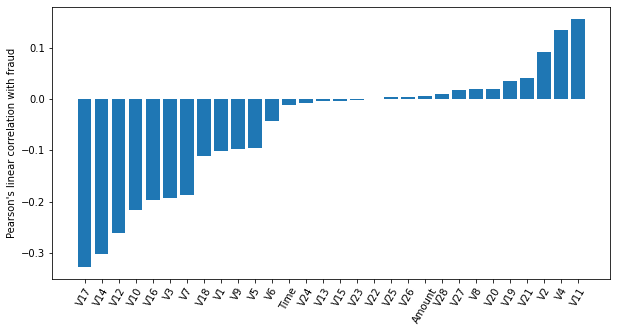

In [22]:
plt.figure(figsize = (10, 5))
plt.bar(corrs.index, corrs.values)
plt.xticks(rotation=60)
plt.ylabel("Pearson's linear correlation with fraud")

As you can see there are not very strong linear correlations between fraud and any of the variables (>0.7), but there does seem so be moderate correlation in some of the variables like V17 and V14

# MACHINE LEARNING MODELS

As we've seen so far, the dataset is very unbalanced, with less than 500 fraudulent transactions and over 280,000 total transactions. This has made it more dificult to do the data analysis and will also make it more dificult for machine learning models to learn.

I'm going to solve this using three approaches, training a linear model and an ensemble method on each one. To test each method I first split the data into training and testing then I apply the approaches:

- Weighted Classification: Weighted Classification consits of applying larger importance in training on the class that has less samples.
- Undersampling: Undersampling simply means removing some of the non-fraudulent data in this case. This approach will waste the majority of the collected data.
- Augmentation: We can try to generate data that is similar to the fraudulent one to try to create a more balanced dataset

$\textbf{Evaluating Models:}$

To evaluate the models we are interested in 2 things, the precision and recall of the *fraudulent transactions*.

I am not really interested in accuracy as classifying everything as non-fraudulent would result in close to 100% accuracy, it is interesting to see how many fraudulent transactions we are able to detect, and out of the transactions we label as fradulent how many are actually fraudulent.

We don't want to miss fraudulent transactions as this would be very bad for the customer

We also don't want to incorrectly classify transactions as fraudulent as this would be inconvenient for the customer if their transactions keep getting cancelled because they are thought to be fraudulent.

We are therefore targeting a recall of fraudulent transactions close to 100%, and a precision as high as possible



$\textbf{Important Terms:}$

- Recall: The percentage of fraudulent transactions that the model correctly identifies as fraudulent
- Precision: Out of the transactions that are labeled as fraudulent, how many of these are actually fraudulent?

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay, ConfusionMatrixDisplay, precision_recall_curve, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
df = df.drop("Time", axis = 1) # I won't use the time but you could definitely look into this further

$\textbf{Min Max Scaling:}$

In [25]:
y = df["Class"].values
X = df.drop("Class", axis = 1)

#NORMALISE
X = (X-X.min())/(X.max()-X.min()) # min max

# X = (X - X.mean())/X.std().values #standard normalisation

In [26]:
X.describe().round(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,0.96,0.77,0.84,0.25,0.77,0.26,0.27,0.79,0.46,0.51,...,0.58,0.56,0.51,0.67,0.38,0.58,0.43,0.42,0.31,0.00
std,0.03,0.02,0.03,0.06,0.01,0.01,0.01,0.01,0.04,0.02,...,0.01,0.01,0.03,0.01,0.08,0.03,0.08,0.01,0.01,0.01
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.94,0.76,0.82,0.21,0.76,0.26,0.26,0.78,0.44,0.50,...,0.58,0.56,0.48,0.66,0.33,0.56,0.37,0.42,0.31,0.00
50%,0.96,0.77,0.84,0.25,0.77,0.26,0.27,0.79,0.46,0.51,...,0.58,0.56,0.51,0.67,0.39,0.58,0.42,0.42,0.31,0.00
75%,0.98,0.78,0.86,0.28,0.77,0.27,0.27,0.79,0.48,0.52,...,0.58,0.56,0.53,0.67,0.44,0.60,0.46,0.42,0.31,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [27]:
X_columns = X.columns

In [28]:
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
np.bincount(y_test)

array([93838,   149], dtype=int64)

## Weighted Classification

By applying weights to each class we are able to force our model to focus more on the class with less samples

### Weighted Logistic Regression

In [30]:
weighted_clf = LogisticRegression(penalty="l2", class_weight="balanced", max_iter = 10000)

In [31]:
weights = len(X) / (2 * np.bincount(y))

In [32]:
print("The weights to each class are: ", weights)

The weights to each class are:  [  0.50086524 289.43800813]


In [33]:
weighted_clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

$\textbf{Result:}$

In [34]:
def plot_result(pred, test):
    c = (pd.DataFrame(classification_report(test, pred, output_dict = True))*100).round(2)
    c.columns = ["Non Fraudulent", "Fraudulent", "Accuracy", "Marco Avg", "Weighted Avg"]
    return(c)

In [35]:
weighted_log_reg = weighted_clf.predict(X_test)
c =  plot_result(weighted_log_reg, y_test)
c

,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.98,6.22,97.82,53.10,99.84
recall,97.83,90.60,97.82,94.22,97.82
f1-score,98.90,11.63,97.82,55.26,98.76
support,9383800.00,14900.00,97.82,9398700.00,9398700.00


The important numbers here are the recall and precision for fraudulent data. As you can see, we only catch around 6% of fraudulent transactions (recall 6% of fraudulent data)

### Weighed Random Forest

In [36]:
weighted_RF_clf = RandomForestClassifier(class_weight= "balanced")

In [37]:
weighted_RF_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [38]:
weighted_rf = weighted_RF_clf.predict(X_test)
c =  plot_result(weighted_rf, y_test)
c

,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.96,94.17,99.95,97.06,99.95
recall,99.99,75.84,99.95,87.92,99.95
f1-score,99.98,84.01,99.95,92.00,99.95
support,9383800.00,14900.00,99.95,9398700.00,9398700.00


This model is already very good with 97% of all fraudulent transactions detected by the model

## Undersampling

Undersampling is a way to make the datasets balanced by just avoiding to use most of the non-fraudulent data. The problem with this is that we stop using most of our data and only end up using a very small fraction

### Undersampling Logistic Regression

In [39]:
print("In the training set there are ", np.bincount(y_train)[0], "non fraudulent transactions and", np.bincount(y_train)[1], "fraudulent")

In the training set there are  190477 non fraudulent transactions and 343 fraudulent


In [40]:
indices = [np.random.choice(np.bincount(y_train)[0], np.bincount(y_train)[1])][0]

In [41]:
X_train_balanced = np.concatenate([X_train[y_train == 0][indices], X_train[y_train == 1]], axis = 0)
y_train_balanced = np.concatenate([y_train[y_train == 0][indices], y_train[y_train == 1]], axis = 0)

We select 343 random non-fraudulent samples and use them in training

In [42]:
print("Count of fraudulent and non fraudulent: ", np.bincount(y_train_balanced))

Count of fraudulent and non fraudulent:  [343 343]


In [43]:
undersampled_clf = LogisticRegression(penalty="l2", class_weight="balanced", max_iter = 10000)

In [44]:
undersampled_clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [45]:
undersampled_log_reg = undersampled_clf.predict(X_test)
c =  plot_result(undersampled_log_reg, y_test)
c

,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.98,31.86,99.68,65.92,99.87
recall,99.70,87.25,99.68,93.48,99.68
f1-score,99.84,46.68,99.68,73.26,99.76
support,9383800.00,14900.00,99.68,9398700.00,9398700.00


Undersampling worked much better for the logistic regression

### Undersampling Random Forest

In [46]:
undersampled_RF_clf = RandomForestClassifier()
undersampled_RF_clf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier()

In [47]:
undersampled_rf = undersampled_RF_clf.predict(X_test)
c =  plot_result(undersampled_rf, y_test)
c

,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.99,4.00,96.44,51.99,99.84
recall,96.44,93.29,96.44,94.87,96.44
f1-score,98.18,7.67,96.44,52.93,98.04
support,9383800.00,14900.00,96.44,9398700.00,9398700.00


Undersampling made random forest worse

## Data Augmentation

Here I try augment the data using bayesian networks

In [48]:
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.DataDescriber import DataDescriber


In [49]:
fraud_norm = pd.DataFrame(X_train[y_train == 1], columns = X_columns)
nofraud_norm = pd.DataFrame(X_train[y_train == 0], columns = X_columns)

$\textbf{Generating, Saving and Loading Synthetic Data:}$

In [50]:
train_file = "creditcardfraud/fraud_train.csv"
pd.DataFrame(X_train[y_train == 1], columns = X_columns).to_csv(train_file)

# describer = DataDescriber()
# describer.describe_dataset_in_correlated_attribute_mode(dataset_file= train_file, 
#                                                         epsilon=0, 
#                                                         k=4)
# describer.save_dataset_description_to_file("description.json")

n_fraudulent = len(X_train[y_train == 0]) - len(X_train[y_train == 1])

# generator = DataGenerator()
# generator.generate_dataset_in_correlated_attribute_mode(n_fraudulent, "description.json")
# generator.save_synthetic_data("sythetic_data2.csv")

synth = pd.read_csv("sythetic_data.csv", index_col =False).iloc[:, 1:]

In [51]:
print("I generated", synth.shape[0], "new synthetic fraudulent transactions")

I generated 190134 new synthetic fraudulent transactions


In [146]:
np.bincount(y_test)

array([93838,   149], dtype=int64)

$\textbf{Comparison to real fraudulent transactions:}$

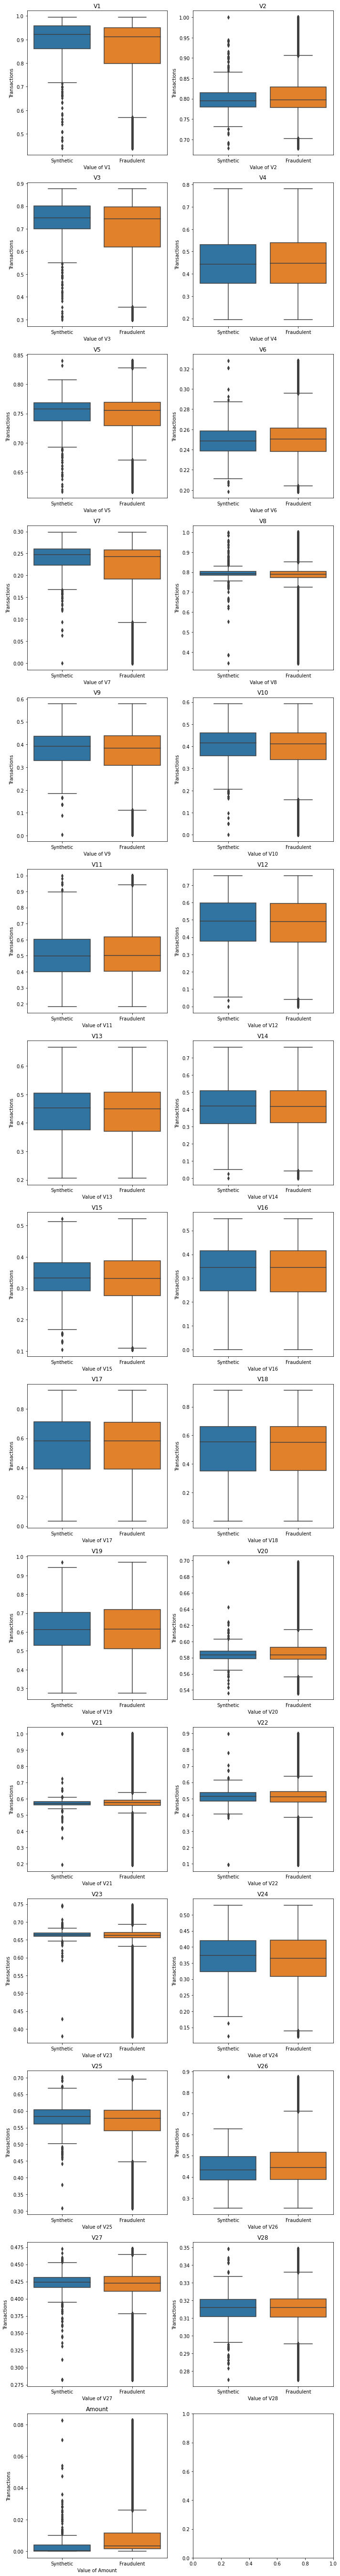

In [153]:
plot_data(fraud_norm,  synth, labels = ["Fraudulent", "Synthetic"], features = list(X_columns))

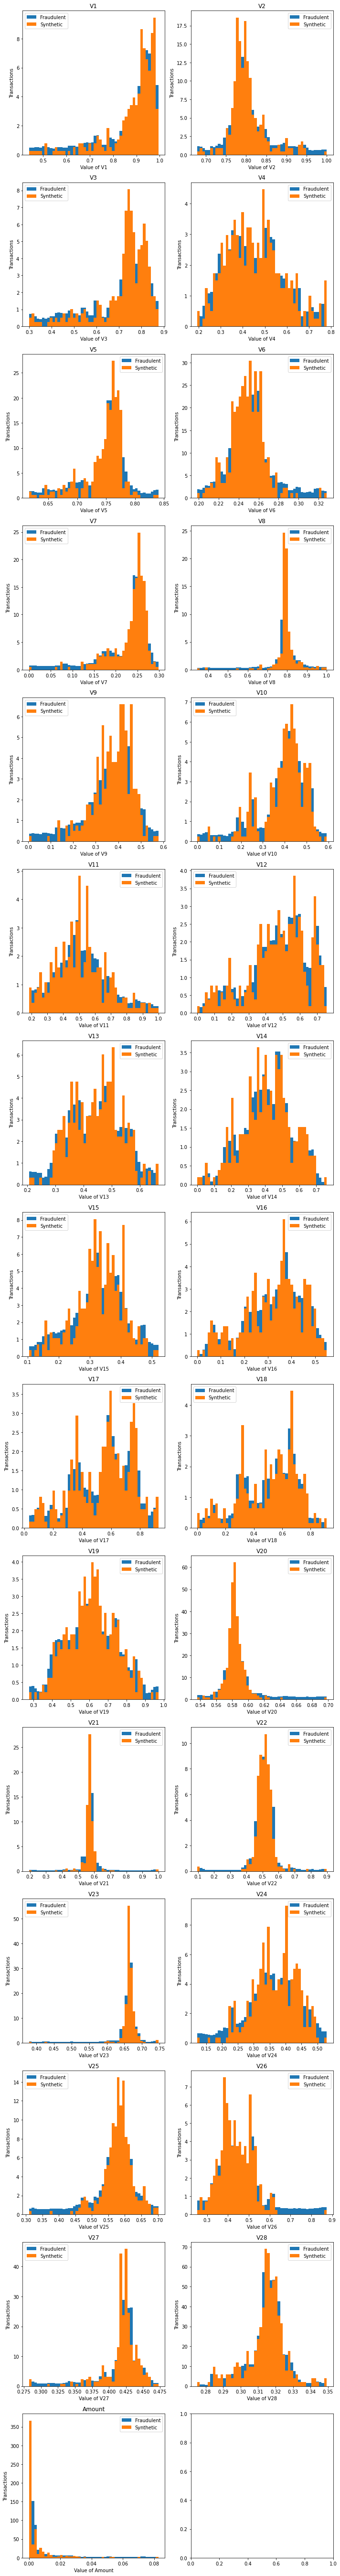

In [154]:
plot_data(fraud_norm,  synth, labels = ["Fraudulent", "Synthetic"], box = False, features = list(X_columns))

### Augmented Random Forest

In [54]:
X_train_augmented = np.concatenate([X_train, synth], axis = 0)
y_train_augmented = np.concatenate([y_train, [1]*len(synth)])

In [144]:
(y_train == 1).sum()

343

In [55]:
print("Total number of non fraudulent and fraudulent transactions: ", np.bincount(y_train_augmented))

Total number of non fraudulent and fraudulent transactions:  [190477 190477]


In [56]:
augmented_RF_clf = RandomForestClassifier()
augmented_RF_clf.fit(X_train_augmented, y_train_augmented)

RandomForestClassifier()

In [57]:
augmented_rf = augmented_RF_clf.predict(X_test)
c =  plot_result(augmented_rf, y_test)
c

,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.98,54.39,99.86,77.19,99.91
recall,99.88,87.25,99.86,93.57,99.86
f1-score,99.93,67.01,99.86,83.47,99.88
support,9383800.00,14900.00,99.86,9398700.00,9398700.00


In [58]:
augmented_rf_train = augmented_RF_clf.predict(X_train)
c =  plot_result(augmented_rf_train, y_train)
c

,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,100.0,100.0,100.0,100.0,100.0
recall,100.0,100.0,100.0,100.0,100.0
f1-score,100.0,100.0,100.0,100.0,100.0
support,19047700.0,34300.0,100.0,19082000.0,19082000.0


In [59]:
# Its overfitting 

In [60]:
# synth_red = synth.sample(10000)

In [61]:
# X_train_augmented = np.concatenate([X_train, synth_red], axis = 0)
# y_train_augmented = np.concatenate([y_train, [1]*len(synth_red)])

In [62]:
# RF_clf = RandomForestClassifier(class_weight='balanced')
# RF_clf.fit(X_train_augmented, y_train_augmented)

In [63]:
# augmented_rf_undersampled = RF_clf.predict(X_test)
# c =  plot_result(augmented_rf_undersampled, y_test)
# c

### Logistic Regression with Data Augmentation

In [64]:
X_train_augmented = np.concatenate([X_train, synth], axis = 0)
y_train_augmented = np.concatenate([y_train, [1]*len(synth)])

In [65]:
augmented_clf = LogisticRegression(penalty="l2", class_weight="balanced", max_iter = 10000)
augmented_clf.fit(X_train_augmented, y_train_augmented)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [66]:
augmented_log_reg = augmented_clf.predict(X_test)
c =  plot_result(augmented_log_reg, y_test)
c

,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.98,10.78,98.81,55.38,99.84
recall,98.83,89.26,98.81,94.04,98.81
f1-score,99.40,19.23,98.81,59.32,99.27
support,9383800.00,14900.00,98.81,9398700.00,9398700.00


### Neural Net with Data Augmentation

In [67]:
X_train_augmented.shape

(380954, 29)

In [68]:
y_train_augmented

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [69]:
nn_inp = np.eye(2)[y_train_augmented]

In [70]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(29, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(29, activation='relu'),
    tf.keras.layers.Dense(2, activation="softmax") #sigmoid for 1 output, using softmax for 2 outputs because I want my recall metric to only count the recall of fraud transactions
])

# If one dimensional output use sigmoid and binarycrossentropy (in pytorch we dont use an activation on the final layer)
# if 2 dimensional output use softmax and categorical cross entropy
#https://stats.stackexchange.com/questions/207049/neural-network-for-binary-classification-use-1-or-2-output-neurons
#https://stackoverflow.com/questions/61122824/when-using-the-cross-entropy-function-for-binary-classification-a-big-gap-betwe

In [71]:
# import tensorflow_addons as tfa
# recall = tf.keras.metrics.Recall()#thresholds=0.9999, class_id=1)
# acc = tf.keras.metrics.Accuracy()
# f5 = tfa.metrics.FBetaScore(num_classes = 2,
#     beta= 5.0, class_id=1,
#     threshold= 0.99,
# )
# opt = tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#     name='Adam'
# )
# history = model.compile(optimizer=opt,
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=[acc, recall, f5])

In [72]:
# sample_weight = np.ones(shape=(len(X_train_augmented),))
# sample_weight[list(y_train == 1) + [False] * (len(X_train_augmented) - len(y_train))] = 2

In [73]:
# model.fit(X_train_augmented, nn_inp, epochs=10, sample_weight = sample_weight)#class_weight = {0: 1, 1: 2})

In [74]:
neural_net_probs = model.predict(X_test)
# neural_net = [1 if i >= 0.5 else 0 for i in neural_net_probs]
neural_net = np.argmax(neural_net_probs, axis = 1)
c =  plot_result(neural_net, y_test)
c

C:\Users\UnzuetaRuedasD\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\UnzuetaRuedasD\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\UnzuetaRuedasD\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.84,0.0,99.84,49.92,99.68
recall,100.00,0.0,99.84,50.00,99.84
f1-score,99.92,0.0,99.84,49.96,99.76
support,9383800.00,14900.0,99.84,9398700.00,9398700.00


In [75]:
# neural_net_probs_train = model.predict(X_train)
# # neural_net_train = [1 if i >= 0.5 else 0 for i in neural_net_probs_train]
# neural_net_train = np.argmax(neural_net_probs_train, axis = 1)
# c =  plot_result(neural_net_train, y_train)
# c

# ANALYSIS OF RESULTS

The best model turned out to be the weighted random forest. I am going to show precision and recall bar charts for both models. I will not show F1 score as I don't think it is a good measure here since it gives precision and recall the same importance. In my opinion recall here matters a lot more, and specifically only recall of the fraudulent class.

In [119]:
from matplotlib.colors import ListedColormap
from matplotlib import cm

In [77]:
preds = [[weighted_log_reg, weighted_rf], [undersampled_log_reg, undersampled_rf],[augmented_log_reg, augmented_rf]]

recall = []
precision = []
for i in preds:
    recall_i = []
    precision_i = []
    for j in i:
        recall_i.append((pd.DataFrame(classification_report(y_test, j, output_dict = True))*100).round(2)["1"][1])
        precision_i.append((pd.DataFrame(classification_report(y_test, j, output_dict = True))*100).round(2)["1"][0])
    recall.append(recall_i)
    precision.append(precision_i)
    
results_dict = {"Fraud Recall":[], "Fraud Precision" : [], "Method":[], "Model":[]}
methods = ["Weighted", "Undersampled", "Augmented"]

for index, (i, j) in enumerate(zip(recall, precision)):
    results_dict["Fraud Recall"].append(i[0])
    results_dict["Fraud Precision"].append(j[0])
    results_dict["Method"].append(methods[index])
    results_dict["Model"].append("Logistic Regression")
    
    results_dict["Fraud Recall"].append(i[1])
    results_dict["Fraud Precision"].append(j[1])
    results_dict["Method"].append(methods[index])
    results_dict["Model"].append("Random Forest")
    
results_dict = pd.DataFrame(results_dict)

$\textbf{Analysis of Precision and Recall:}$

Text(0.5, 1.0, 'Recall of Fraud')

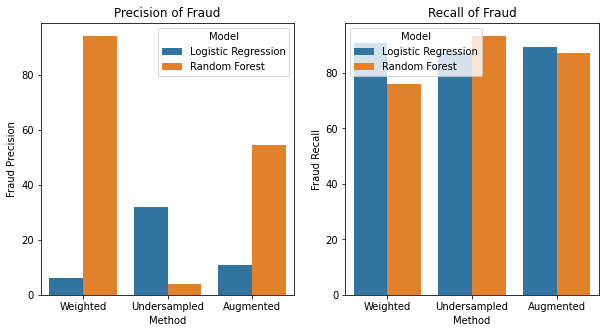

In [78]:
_, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.barplot(data = results_dict, x = "Method", y = "Fraud Precision", hue = "Model", ax = ax[0])
ax[0].set_title("Precision of Fraud")
sns.barplot(data = results_dict, x = "Method", y = "Fraud Recall", hue = "Model")
ax[1].set_title("Recall of Fraud")

$\textbf{Choosing Models With High Precision:}$

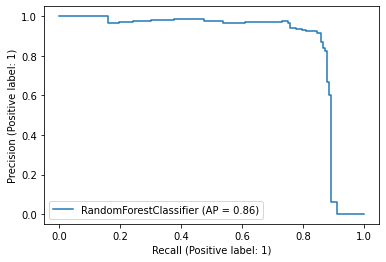

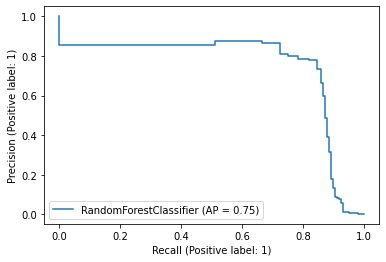

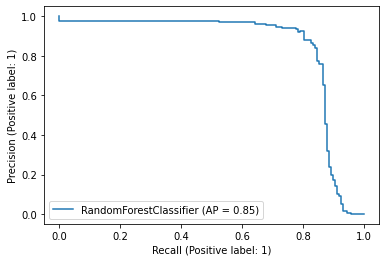

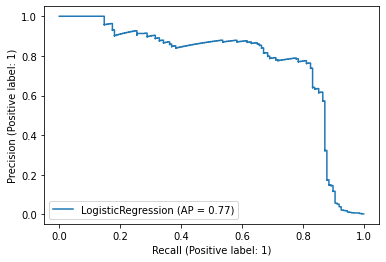

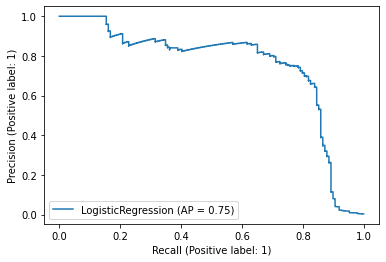

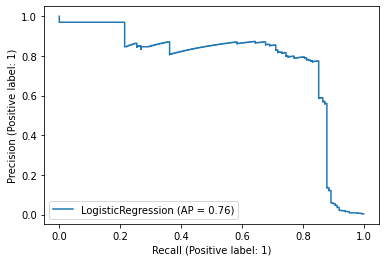

In [79]:
models = [weighted_RF_clf, undersampled_RF_clf, augmented_RF_clf]
displays = []
for i in models:
    displays.append(PrecisionRecallDisplay.from_estimator(i, X_test, y_test))

linear_models = [weighted_clf, undersampled_clf, augmented_clf]
linear_displays = []
for i in linear_models:
    linear_displays.append(PrecisionRecallDisplay.from_estimator(i, X_test, y_test))


In [155]:
def plot_recall_precision(xlim = 0):
    _, ax = plt.subplots(1,2, figsize = (13,6.5))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []

    for axis in ax:
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            (l,) = axis.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
            axis.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
            axis.set_xlim([xlim, 1.0])
            axis.set_ylim([0.0, 1.05])

    displays[0].plot(ax = ax[0], label = "Weighted Random Forest")
    displays[1].plot(ax = ax[0], label = "Undersampled Random Forest")
    displays[2].plot(ax = ax[0], label = "Augmented Random Forest")

    linear_displays[0].plot(ax = ax[1], label = "Weighted Logistic Regression")
    linear_displays[1].plot(ax = ax[1], label = "Undersampled Logistic Regression")
    linear_displays[2].plot(ax = ax[1], label = "Augmented Logistic Regression")

    for axis in ax:
        axis.set_xlabel("Recall of Fraudulent Transactions")
        axis.set_ylabel("Precision of Fraudulent Transactions")

    ax[0].set_title("Random Forest and Neural Net")
    ax[1].set_title("Linear Models")


    # precision, recall, threshhold = precision_recall_curve(y_test, neural_net_probs[:, 1])
    # ax[0].plot(recall, precision, label = "Augmented Neural Network")

    # t = 0.8
    # close_default_clf = np.argmin(np.abs(threshhold - t))
    # ax[0].plot(recall[close_default_clf], precision[close_default_clf], '*', c='r',
    #             markersize=10, label = "High Recall intermediate Precision")






    augmented_prob = weighted_RF_clf.predict_proba(X_test)[:, 1]
    precision, recall, threshhold = precision_recall_curve(y_test, augmented_prob)
    t = 0.3
    close_default_clf = np.argmin(np.abs(threshhold - t))
    ax[0].plot(recall[close_default_clf], precision[close_default_clf], '*', c='r',
                markersize=10, label = "High F1 Score")


    # weighted_prob = weighted_RF_clf.predict_proba(X_test)[:, 1]
    # precision, recall, threshhold = precision_recall_curve(y_test, weighted_prob)
    t = 0.055
    close_default_clf = np.argmin(np.abs(threshhold - t))
    ax[0].plot(recall[close_default_clf], precision[close_default_clf], '*', c='k',
                markersize=10, label = "Weighted RF High R Intermediate P")

    augmented_prob = augmented_RF_clf.predict_proba(X_test)[:, 1]
    precision, recall, threshhold = precision_recall_curve(y_test, augmented_prob)
    t = 0.25
    close_default_clf = np.argmin(np.abs(threshhold - t))
    ax[0].plot(recall[close_default_clf], precision[close_default_clf], '*', c='g',
                markersize=10, label = "Augmented RF High Recall")


    ax[0].legend()

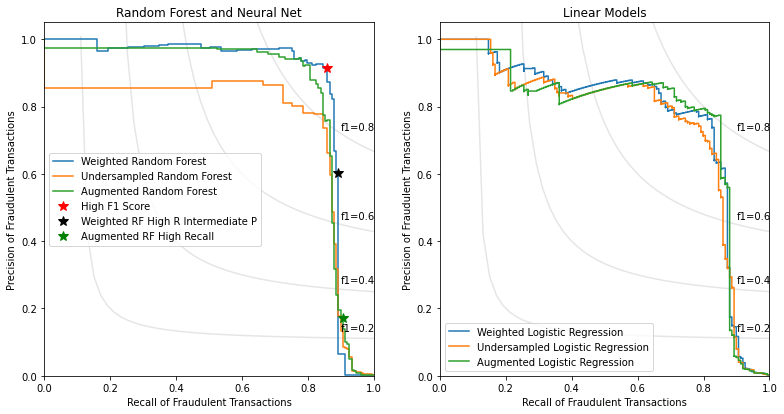

In [156]:
plot_recall_precision(xlim = 0)

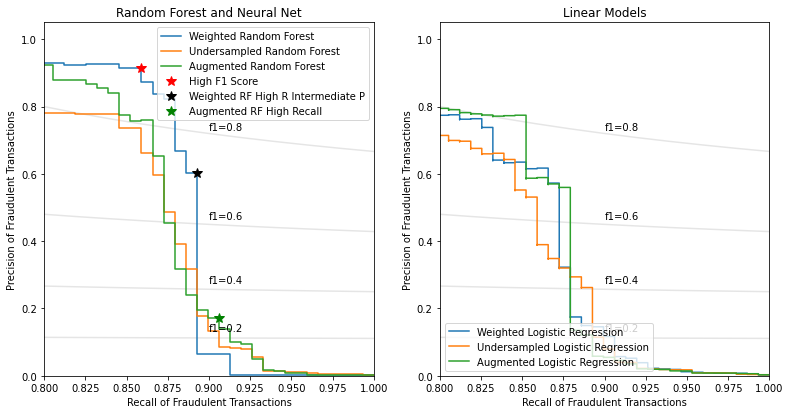

In [157]:
plot_recall_precision(xlim = 0.8)

In [109]:
def get_preds_from_threshhold(t, model, X_test, y_test):
    try:
        probs = model.predict_proba(X_test)[:, 1]
    except:
        probs = model.predict(X_test)[:, 1]
    precision, recall, threshhold = precision_recall_curve(y_test, probs)
    
    close_default_clf = np.argmin(np.abs(threshhold - t))
    
    improved_augmented_RF_clf = np.array([1 if y >= threshhold[close_default_clf] else 0 for y in probs])
    return(improved_augmented_RF_clf)

In [110]:
model1 = get_preds_from_threshhold(0.3, weighted_RF_clf, X_test, y_test)

In [111]:
plot_result(model1, y_test)


,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.98,91.43,99.96,95.70,99.96
recall,99.99,85.91,99.96,92.95,99.96
f1-score,99.98,88.58,99.96,94.28,99.96
support,9383800.00,14900.00,99.96,9398700.00,9398700.00


In [112]:
model2 = get_preds_from_threshhold(0.055, weighted_RF_clf, X_test, y_test)

In [113]:
plot_result(model2, y_test)


,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.98,60.18,99.89,80.08,99.92
recall,99.91,89.26,99.89,94.58,99.89
f1-score,99.94,71.89,99.89,85.92,99.90
support,9383800.00,14900.00,99.89,9398700.00,9398700.00


In [114]:
model3 = get_preds_from_threshhold(0.25, augmented_RF_clf, X_test, y_test)

In [116]:
plot_result(model3, y_test)


,Non Fraudulent,Fraudulent,Accuracy,Marco Avg,Weighted Avg
precision,99.98,17.26,99.3,58.62,99.85
recall,99.31,90.60,99.3,94.96,99.30
f1-score,99.65,29.00,99.3,64.32,99.53
support,9383800.00,14900.00,99.3,9398700.00,9398700.00


In [139]:
model_names = ["Weighted RF Max F1", "Weighted RF High R Intermediate P", "Augmented RF High Recall"]

Text(0, 0.5, 'F30')

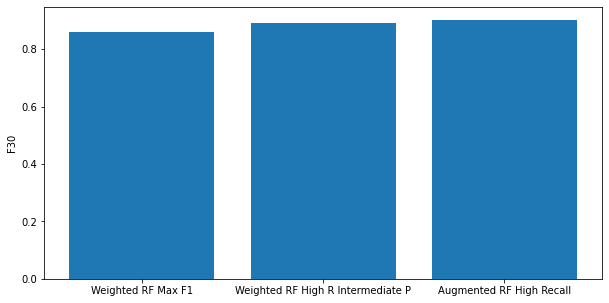

In [174]:
plt.figure(figsize = (10,5))
beta = 30

plt.bar(model_names, [fbeta_score(y_test, model1, beta = beta), fbeta_score(y_test, model2, beta = beta), fbeta_score(y_test, model3, beta = beta)])
plt.ylabel("F30")
# plt.xticks(rotation=10)

In [142]:
cm.get_cmap('Oranges_r', 128)

Text(0.5, 1.0, 'Augmented RF High Recall')

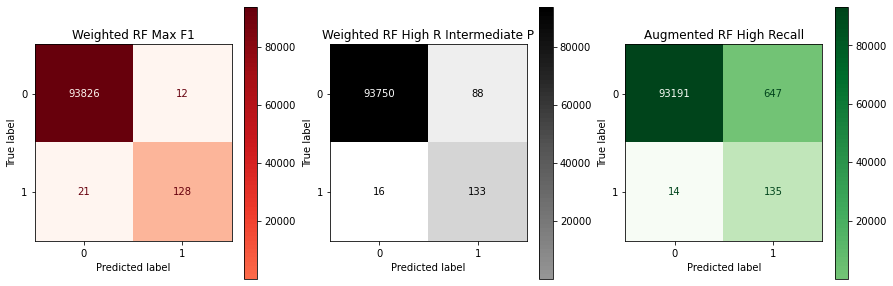

In [143]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

top = cm.get_cmap('Reds', 128)
bottom = cm.get_cmap('Reds', 128)

newcolors = np.vstack((top(np.linspace(0, 0.5, 12)),
                       bottom(np.linspace(0.5, 1, 5000))))
newcmp_blues = ListedColormap(newcolors)

top = cm.get_cmap('Greys', 128)
bottom = cm.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0, 0.5, 12)),
                       bottom(np.linspace(0.5, 1, 5000))))
newcmp_reds = ListedColormap(newcolors)

top = cm.get_cmap('Greens', 128)
bottom = cm.get_cmap('Greens', 128)

newcolors = np.vstack((top(np.linspace(0, 0.5, 12)),
                       bottom(np.linspace(0.5, 1, 5000))))
newcmp_greys = ListedColormap(newcolors)



ConfusionMatrixDisplay(confusion_matrix(y_test, model1)).plot(ax = ax[0], cmap = newcmp_blues)
ConfusionMatrixDisplay(confusion_matrix(y_test, model2)).plot(ax = ax[1], cmap = newcmp_reds)
ConfusionMatrixDisplay(confusion_matrix(y_test, model3)).plot(ax = ax[2], cmap = newcmp_greys)

ax[0].set_title(model_names[0])
ax[1].set_title(model_names[1])
ax[2].set_title(model_names[2])

93838

In [165]:
647/(y_test == 0).sum()*100

0.6894861356806411

In [166]:
135/(y_test == 1).sum() * 100

90.60402684563759

In [170]:
88/(y_test == 0).sum() * 100

0.0937786397834566

In [171]:
133/(y_test == 1).sum()*100

89.26174496644296

The most important factor is the recall of Fraudulent data, and therefore I think the best model is the weighted random forest model. Even if it's precision is slightly lower, that is worth it for the increase in recall of fraudulent data

$\textbf{Analysis of Best Model:}$

In [ ]:
X_test_analysis = pd.DataFrame(X_test)
X_test_analysis.columns = X_columns

# UN-NORMALISE 
X = df.drop("Class", axis = 1)
X_test_analysis = X_test_analysis *(X.max()-X.min()) + X.min()# (X-X.min())/(X.max()-X.min()) # min max


X_test_analysis["pred"] = weighted_RF_clf_t0029
X_test_analysis["real"] = y_test

In [ ]:
print("The average transaction in the test set was", round(X_test_analysis["Amount"].describe()["mean"], 2))

In [ ]:
TP = X_test_analysis.loc[(X_test_analysis["pred"] == 1) & (X_test_analysis["real"] == 1)]
FP = X_test_analysis.loc[(X_test_analysis["pred"] == 1) & (X_test_analysis["real"] == 0)]
FN = X_test_analysis.loc[(X_test_analysis["pred"] == 0) & (X_test_analysis["real"] == 1)]
TN = X_test_analysis.loc[(X_test_analysis["pred"] == 0) & (X_test_analysis["real"] == 0)]

In [ ]:
print("Out of the total ", len(X_test_analysis), " transactions in the test set out of which ",  (X_test_analysis["real"] == 1).sum())

This model correctly identifies 116 transactions as fraudulent in the test set, and 93834 as non fraudulent. It only misses 4 fraudulent transactions, and it missclasifies 33 transactions as fraudulent when they aren't. This is quite a satisfactory result. Let's try to find out why it might have missclasified those 37 samples

In [ ]:
FN["Amount"] 

In [ ]:
plot_data(fraud,  FP, labels = ["Fraudulent", "Missclasified"], features = list(X_columns))